# Airbnb Listing Data 2023

## By: Mario Hernández

Configuración del ambiente de Google Colaboratory con Pyspark y Hadoop

In [1]:
# Download Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 from here.
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
# Now, we just need to unzip that folder.
!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setting JVM and Spark path variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Installing required packages
!pip install pyspark==3.5.1
!pip install findspark

--2024-08-23 04:26:52--  https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz’

spark-3.5.1-bin-had 100%[===================>] 381.90M  21.0MB/s    in 17s     

2024-08-23 04:27:10 (22.8 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz’ saved [400446614/400446614]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=05ab63d251056ffeaf6028d5196ec47cd600a228276f65186679029994e13c66
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built py

Importamos Librerias

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.io as pio

import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, DateType
from pyspark.sql import functions as fct
from pyspark.ml  import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean,col,split,regexp_extract,when,lit,sum,desc,to_date,expr,round,avg,max,count,regexp_replace, trim
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

Creamos la sesión de spark

In [38]:
SpSession = SparkSession \
          .builder \
          .appName("Airbnb Spark") \
          .getOrCreate()

In [39]:
SpContext = SpSession.sparkContext

Importamos los datos y los visualizamos

In [40]:
df1 = SpSession.read.csv('/content/airnb.csv', header=True, sep=",")
df1.show(5)

df2 = SpSession.read.csv('/content/airnb_desert.csv', header=True, sep=",")
df2.show(5)

df3 = SpSession.read.csv('/content/airnb_luxe.csv', header=True, sep=",")
df3.show(5)

+--------------------+--------------------+-----------+----------------+----------------------+-----------------+-------------+
|               Title|              Detail|       Date|Price(in dollar)|Offer price(in dollar)|Review and rating|Number of bed|
+--------------------+--------------------+-----------+----------------+----------------------+-----------------+-------------+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|          306.00|                229.00|       4.85 (531)|       4 beds|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|          485.00|                170.00|       4.77 (146)|       4 beds|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|          119.00|                522.00|       4.91 (515)|       4 beds|
|Home in Blue Ridg...|*Summer Sizzle* 5...|Jun 11 - 16|          192.00|                348.00|        4.94 (88)|       5 beds|
|Treehouse in Gran...|Luxury Treehouse ...|  Jun 4 - 9|          232.00|                196.00|       4.

Exploración de los datos

In [41]:
#Esquema relacional del conjunto de datos
df1.printSchema()
df2.printSchema()
df3.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price(in dollar): string (nullable = true)
 |-- Offer price(in dollar): string (nullable = true)
 |-- Review and rating: string (nullable = true)
 |-- Number of bed: string (nullable = true)

root
 |-- Desert name: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price(In dollar): string (nullable = true)
 |-- Details: string (nullable = true)
 |-- Rating: string (nullable = true)

root
 |-- Luxe name: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price(In dollar): string (nullable = true)
 |-- Distance: string (nullable = true)



In [42]:
# Imprime el tipo de datos de cada columna en df1
for field in df1.schema.fields:
    print(f"Columna '{field.name}' tipo de dato: {field.dataType}")

print("\n")

# Imprime el tipo de datos de cada columna en df2
for field in df2.schema.fields:
    print(f"Columna '{field.name}' tipo de dato: {field.dataType}")

print("\n")

# Imprime el tipo de datos de cada columna en df3
for field in df3.schema.fields:
    print(f"Columna '{field.name}' tipo de dato: {field.dataType}")


Columna 'Title' tipo de dato: StringType()
Columna 'Detail' tipo de dato: StringType()
Columna 'Date' tipo de dato: StringType()
Columna 'Price(in dollar)' tipo de dato: StringType()
Columna 'Offer price(in dollar)' tipo de dato: StringType()
Columna 'Review and rating' tipo de dato: StringType()
Columna 'Number of bed' tipo de dato: StringType()


Columna 'Desert name' tipo de dato: StringType()
Columna 'Date' tipo de dato: StringType()
Columna 'Price(In dollar)' tipo de dato: StringType()
Columna 'Details' tipo de dato: StringType()
Columna 'Rating' tipo de dato: StringType()


Columna 'Luxe name' tipo de dato: StringType()
Columna 'Date' tipo de dato: StringType()
Columna 'Price(In dollar)' tipo de dato: StringType()
Columna 'Distance' tipo de dato: StringType()


In [43]:
#Características estadísticas básicas
df1.describe().show()
df2.describe().show()
df3.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+----------------------+-----------------+-------------+
|summary|               Title|              Detail|                Date|  Price(in dollar)|Offer price(in dollar)|Review and rating|Number of bed|
+-------+--------------------+--------------------+--------------------+------------------+----------------------+-----------------+-------------+
|  count|                 957|                 957|                 953|               949|                   172|              951|          949|
|   mean|                NULL|                NULL|                99.0|170.51797040169134|    149.90419161676647|             NULL|         NULL|
| stddev|                NULL|                NULL|    88.1702897806285|135.57467024158484|    134.32384144266746|             NULL|         NULL|
|    min|A Resort by the Sea"|""" La cabane du ...| rural tourism. Y...|          1,463.00|              1,089.00|    

In [44]:
# Número de registros
print("Count df1:", df1.count())
print("Count df2:", df2.count())
print("Count df3:", df3.count())


Count df1: 957
Count df2: 280
Count df3: 280


Preparación de los datos, consultas y transformaciones

In [45]:
# Función para contar valores nulos en cada columna
for column in df1.columns:
    null_count = df1.filter(col(column).isNull()).count()
    print(f"Valores nulos en '{column}': {null_count}")
print("\n")
# Función para contar valores nulos en cada columna
for column in df2.columns:
    null_count = df2.filter(col(column).isNull()).count()
    print(f"Valores nulos en '{column}': {null_count}")
print("\n")
# Función para contar valores nulos en cada columna
for column in df3.columns:
    null_count = df3.filter(col(column).isNull()).count()
    print(f"Valores nulos en '{column}': {null_count}")

Valores nulos en 'Title': 0
Valores nulos en 'Detail': 0
Valores nulos en 'Date': 4
Valores nulos en 'Price(in dollar)': 8
Valores nulos en 'Offer price(in dollar)': 785
Valores nulos en 'Review and rating': 6
Valores nulos en 'Number of bed': 8


Valores nulos en 'Desert name': 0
Valores nulos en 'Date': 0
Valores nulos en 'Price(In dollar)': 0
Valores nulos en 'Details': 0
Valores nulos en 'Rating': 0


Valores nulos en 'Luxe name': 0
Valores nulos en 'Date': 0
Valores nulos en 'Price(In dollar)': 0
Valores nulos en 'Distance': 0


In [46]:
# Elimina la columna 'OfferPrice' de df1
df1 = df1.drop('Offer price(in dollar)')
df1.show(3)

+--------------------+--------------------+-----------+----------------+-----------------+-------------+
|               Title|              Detail|       Date|Price(in dollar)|Review and rating|Number of bed|
+--------------------+--------------------+-----------+----------------+-----------------+-------------+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|          306.00|       4.85 (531)|       4 beds|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|          485.00|       4.77 (146)|       4 beds|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|          119.00|       4.91 (515)|       4 beds|
+--------------------+--------------------+-----------+----------------+-----------------+-------------+
only showing top 3 rows



In [47]:
# Renombrar columnas para unificar
df1 = df1.withColumnRenamed("Price(in dollar)", "Price")
df2 = df2.withColumnRenamed("Price(In dollar)", "Price")
df3 = df3.withColumnRenamed("Price(In dollar)", "Price")

# Renombrar columnas para unificar
df1 = df1.withColumnRenamed("Title", "Name")
df2 = df2.withColumnRenamed("Desert name", "Name")
df3 = df3.withColumnRenamed("Luxe name", "Name")

# Agregar una columna que indique el origen de los datos
df1 = df1.withColumn("Category", lit("Standard"))
df2 = df2.withColumn("Category", lit("Desert"))
df3 = df3.withColumn("Category", lit("Luxe"))

df1.show(3)
df2.show(3)
df3.show(3)


+--------------------+--------------------+-----------+------+-----------------+-------------+--------+
|                Name|              Detail|       Date| Price|Review and rating|Number of bed|Category|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|306.00|       4.85 (531)|       4 beds|Standard|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|485.00|       4.77 (146)|       4 beds|Standard|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|119.00|       4.91 (515)|       4 beds|Standard|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+
only showing top 3 rows

+------------------+----------+---------+--------------------+------+--------+
|              Name|      Date|    Price|             Details|Rating|Category|
+------------------+----------+---------+--------------------+------+--------+
|   Mhamid

In [48]:
# Extraer el mes de la columna 'date' en df1
df1 = df1.withColumn("Month", fct.substring(df1["date"], 1, 3))

# Extraer el mes de la columna 'date' en df2
df2 = df2.withColumn("Month", fct.substring(df2["date"], 1, 3))

# Extraer el mes de la columna 'date' en df3
df3 = df3.withColumn("Month", fct.substring(df3["date"], 1, 3))

df1.show(5)
df2.show(5)
df3.show(5)


+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
|                Name|              Detail|       Date| Price|Review and rating|Number of bed|Category|Month|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|306.00|       4.85 (531)|       4 beds|Standard|  Jun|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|485.00|       4.77 (146)|       4 beds|Standard|  Jun|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|119.00|       4.91 (515)|       4 beds|Standard|  Jul|
|Home in Blue Ridg...|*Summer Sizzle* 5...|Jun 11 - 16|192.00|        4.94 (88)|       5 beds|Standard|  Jun|
|Treehouse in Gran...|Luxury Treehouse ...|  Jun 4 - 9|232.00|       4.99 (222)|  1 queen bed|Standard|  Jun|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
only showi

In [49]:
# Buscamos en month valores diferentes a los meses del año y eliminamos
# Meses válidos
valid_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Filtrar df1 para mantener solo meses válidos
df1 = df1.filter(df1["Month"].isin(valid_months))

# Filtrar df2 para mantener solo meses válidos
df2 = df2.filter(df2["Month"].isin(valid_months))

# Filtrar df3 para mantener solo meses válidos
df3 = df3.filter(df3["Month"].isin(valid_months))

df1.show(5)
df2.show(5)
df3.show(5)

+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
|                Name|              Detail|       Date| Price|Review and rating|Number of bed|Category|Month|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|306.00|       4.85 (531)|       4 beds|Standard|  Jun|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|485.00|       4.77 (146)|       4 beds|Standard|  Jun|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|119.00|       4.91 (515)|       4 beds|Standard|  Jul|
|Home in Blue Ridg...|*Summer Sizzle* 5...|Jun 11 - 16|192.00|        4.94 (88)|       5 beds|Standard|  Jun|
|Treehouse in Gran...|Luxury Treehouse ...|  Jun 4 - 9|232.00|       4.99 (222)|  1 queen bed|Standard|  Jun|
+--------------------+--------------------+-----------+------+-----------------+-------------+--------+-----+
only showi

In [50]:
# Casteamos 'Price' como DoubleType es decir como un valor numérico
df1 = df1.withColumn("Price", regexp_replace("Price", ",", "").cast(DoubleType()))
df2 = df2.withColumn("Price", regexp_replace("Price", ",", "").cast(DoubleType()))
df3 = df3.withColumn("Price", regexp_replace("Price", ",", "").cast(DoubleType()))

df1.show(5)
df2.show(5)
df3.show(5)


+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+
|                Name|              Detail|       Date|Price|Review and rating|Number of bed|Category|Month|
+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+
|Chalet in Skykomi...|Sky Haus - A-Fram...|Jun 11 - 16|306.0|       4.85 (531)|       4 beds|Standard|  Jun|
|Cabin in Hancock,...|The Catskill A-Fr...| Jun 6 - 11|485.0|       4.77 (146)|       4 beds|Standard|  Jun|
|Cabin in West Far...|The Triangle: A-F...| Jul 9 - 14|119.0|       4.91 (515)|       4 beds|Standard|  Jul|
|Home in Blue Ridg...|*Summer Sizzle* 5...|Jun 11 - 16|192.0|        4.94 (88)|       5 beds|Standard|  Jun|
|Treehouse in Gran...|Luxury Treehouse ...|  Jun 4 - 9|232.0|       4.99 (222)|  1 queen bed|Standard|  Jun|
+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+
only showing top 5 

In [51]:
# Dividimos la columna 'Title' en ciudad y país de una manera temporal para separar los lugares del texto que están separados por 1 o más ","
split_col = split(df1['Name'], ',')
df1 = df1.withColumn('city', split_col.getItem(1)) \
       .withColumn('country_temp', split_col.getItem(2))

# Llenamos los valores nulos en 'country_temp' con los valores de 'city' cuando solo hay una coma
df1 = df1.withColumn('country', when(col('country_temp').isNull(), col('city')).otherwise(col('country_temp')))

# Eliminamos la columna temporal 'country_temp'
df1 = df1.drop('country_temp')

# Imprime los valores únicos de 'Country'
df1.select("Country").distinct().show()


+-------------------+
|            Country|
+-------------------+
|            Tunisia|
| Dominican Republic|
|           Colombia|
|            Ireland|
|               Cuba|
|             Taiwan|
|        El Salvador|
|             Canada|
|            Germany|
|            Curaçao|
|                 US|
|                 UK|
|              Spain|
|            Vietnam|
|            Czechia|
|        Philippines|
|            Jamaica|
|        Puerto Rico|
|           Malaysia|
|        Switzerland|
+-------------------+
only showing top 20 rows



In [52]:
# Extraemos el país después de la coma en 'Desert name'
df2 = df2.withColumn("Country", split(col("Name"), ",").getItem(1))

# Imprime los valores únicos de 'Country'
df2.select("Country").distinct().show()

+-------------+
|      Country|
+-------------+
|      Tunisia|
|    Australia|
|       Israel|
|        Aswan|
|        Spain|
|        Egypt|
|         Oman|
|      Morocco|
|       Jordan|
|      Namibia|
|      Morocco|
|        India|
| Saudi Arabia|
|       Greece|
| South Africa|
|          UAE|
+-------------+



In [53]:
# Dividimos la columna 'Luxe name' en ciudad y país de una manera temporal para separar los lugares del texto que están separados por 1 o más ","
split_col = split(df3['Name'], ',')
df3 = df3.withColumn('city', split_col.getItem(1)) \
       .withColumn('country_temp', split_col.getItem(2))

# Llenamos los valores nulos en 'country_temp' con los valores de 'city' cuando solo hay una coma
df3 = df3.withColumn('country', when(col('country_temp').isNull(), col('city')).otherwise(col('country_temp')))

# Eliminamos la columna temporal 'country_temp'
df3 = df3.drop('country_temp')

# Imprime los valores únicos de 'Country'
df3.select("Country").distinct().show()

+-------------+
|      Country|
+-------------+
|      Croatia|
|    Australia|
|     Maldives|
|    Sri Lanka|
|    Mauritius|
|       Turkey|
|   Montenegro|
|    Koh Samui|
|        Italy|
|       Sweden|
|      Austria|
|       Norway|
|    Indonesia|
|     Thailand|
|       Greece|
|      Finland|
| South Africa|
+-------------+



In [54]:
# Unimos los datasets con algunas columnas
df1_subset = df1.select("Name","Price", "Category", "Country")
df2_subset = df2.select("Name","Price", "Category", "Country")
df3_subset = df3.select("Name","Price", "Category", "Country")


df_union = df1_subset.union(df2_subset).union(df3_subset)

df_union.show(5)


+--------------------+-----+--------+-------+
|                Name|Price|Category|Country|
+--------------------+-----+--------+-------+
|Chalet in Skykomi...|306.0|Standard|     US|
|Cabin in Hancock,...|485.0|Standard|     US|
|Cabin in West Far...|119.0|Standard|     US|
|Home in Blue Ridg...|192.0|Standard|     US|
|Treehouse in Gran...|232.0|Standard|     US|
+--------------------+-----+--------+-------+
only showing top 5 rows



In [55]:
# Filtramos las propiedades con precio mayor a 1000 USD
df_filtered = df_union.filter(df_union["Price"] > 1000)

df_filtered.show(truncate=False)

+----------------------------------+-------+--------+--------+
|Name                              |Price  |Category|Country |
+----------------------------------+-------+--------+--------+
|Home in Moss Beach, California, US|1463.0 |Standard| US     |
|Aqaba City, Jordan                |2168.0 |Desert  | Jordan |
|Tamesluht, Morocco                |17752.0|Desert  | Morocco|
|Al Bairat, Egypt                  |1982.0 |Desert  | Egypt  |
|Tamesluht, Morocco                |17752.0|Desert  | Morocco|
|Mitzpe Ramon, Israel              |2502.0 |Desert  | Israel |
|Tinghir, Morocco                  |1346.0 |Desert  | Morocco|
|Mitzpe Ramon, Israel              |2945.0 |Desert  | Israel |
|Merzouga, Morocco                 |2937.0 |Desert  | Morocco|
|Essaouira, Morocco                |5386.0 |Desert  | Morocco|
|Tzofar, Israel                    |1821.0 |Desert  | Israel |
|Ait Bihi, Morocco                 |1096.0 |Desert  | Morocco|
|Al Bairat, Egypt                  |1670.0 |Desert  | E

In [56]:
#Los 10 hospedajes más baratos
df_sorted = df_union.orderBy("Price")
df_sorted.select("Name", "Price").show(10, truncate=False)


+----------------------------------------------------+-----+
|Name                                                |Price|
+----------------------------------------------------+-----+
|Campsite in Rif, Iceland                            |16.0 |
|Campsite in Rif, Iceland                            |16.0 |
|Hotel in Nha Trang, Vietnam                         |17.0 |
|Hut in Guarne, Colombia                             |18.0 |
|Apartment in Bangkok, Thailand                      |19.0 |
|Home in Jumilhac-le-Grand, France                   |20.0 |
|Earthen home in Mueang Chiang Mai District, Thailand|22.0 |
|Earthen home in Mueang Chiang Mai District, Thailand|22.0 |
|Condo in Melaka, Malaysia                           |23.0 |
|Place to stay in Thành phố Hội An, Vietnam          |24.0 |
+----------------------------------------------------+-----+
only showing top 10 rows



In [57]:
# Filtramos las propiedades en Colombia
df_colombia = df_union.filter(df_union["Country"] == " Colombia")

df_colombia.show(truncate=False)

+---------------------------------+-----+--------+---------+
|Name                             |Price|Category|Country  |
+---------------------------------+-----+--------+---------+
|Tiny home in Medellín, Colombia  |67.0 |Standard| Colombia|
|Cabin in Medellín, Colombia      |51.0 |Standard| Colombia|
|Place to stay in Retiro, Colombia|107.0|Standard| Colombia|
|Chalet in Cajicá, Colombia       |40.0 |Standard| Colombia|
|Cabin in El Peñol, Colombia      |220.0|Standard| Colombia|
|Cabin in Santa Marta, Colombia   |61.0 |Standard| Colombia|
|Hut in Guarne, Colombia          |18.0 |Standard| Colombia|
+---------------------------------+-----+--------+---------+



In [58]:
# Filtra las filas 'Review and rating' que no tengan a "None" o "New"
df1_filtered = df1.filter((df1['Review and rating'] != "None") & (df1['Review and rating'] != "New"))

# Ordena el DataFrame filtrado por 'Review and rating' en orden descendente
df1_sorted = df1_filtered.orderBy(desc('Review and rating'))

# Muestra las 10 mejores filas
df1_sorted.show(10)


+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+-----------+----------+
|                Name|              Detail|       Date|Price|Review and rating|Number of bed|Category|Month|       city|   country|
+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+-----------+----------+
| Home in Los Angeles|Hollywood Sunset ...|May 13 - 18|272.0|         5.0 (99)|  2 king beds|Standard|  May|       NULL|      NULL|
|Villa in Kathu, T...|Tiny Poolvilla in...|Jul 25 - 30|119.0|         5.0 (98)|   1 king bed|Standard|  Jul|   Thailand|  Thailand|
|Villa in Kathu, T...|Tiny Poolvilla in...|Jul 25 - 30|119.0|         5.0 (98)|   1 king bed|Standard|  Jul|   Thailand|  Thailand|
|Villa in Morongo ...|Pink Galaxy | Pri...| Jun 7 - 12|283.0|          5.0 (9)|  1 queen bed|Standard|  Jun| California|        US|
|Farm stay in Şark...|Off-Grid vineyard...| Jun 7 - 13|144.0|          5.0 (

In [59]:
# Extrae las calificaicones de Review and rating y crea una nueva columna 'valoración'
df1_sorted = df1_sorted.withColumn('valoración', regexp_extract(col('Review and rating'), '(\d+\.\d+)', 1).cast(DoubleType()))

# Muestra el DataFrame resultante
df1_sorted.show(10)


+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+-----------+----------+----------+
|                Name|              Detail|       Date|Price|Review and rating|Number of bed|Category|Month|       city|   country|valoración|
+--------------------+--------------------+-----------+-----+-----------------+-------------+--------+-----+-----------+----------+----------+
| Home in Los Angeles|Hollywood Sunset ...|May 13 - 18|272.0|         5.0 (99)|  2 king beds|Standard|  May|       NULL|      NULL|       5.0|
|Villa in Kathu, T...|Tiny Poolvilla in...|Jul 25 - 30|119.0|         5.0 (98)|   1 king bed|Standard|  Jul|   Thailand|  Thailand|       5.0|
|Villa in Kathu, T...|Tiny Poolvilla in...|Jul 25 - 30|119.0|         5.0 (98)|   1 king bed|Standard|  Jul|   Thailand|  Thailand|       5.0|
|Villa in Morongo ...|Pink Galaxy | Pri...| Jun 7 - 12|283.0|          5.0 (9)|  1 queen bed|Standard|  Jun| California|        US|       5.0|

Visualizamos los datos

In [60]:
# Convertimos a Pandas
df1_pandas = df1.select("Country").toPandas()

# Agrupamos por país y contamos el número de reservas
country_counts = df1_pandas['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Crearmos una escala de color personalizada relacionada con la temática
color_scale = [
    [0, 'rgba(255, 90, 95, 0.1)'],
    [0.2, 'rgba(255, 90, 95, 0.3)'],
    [0.4, 'rgba(255, 90, 95, 0.5)'],
    [0.6, 'rgba(255, 90, 95, 0.7)'],
    [0.8, 'rgba(255, 90, 95, 0.9)'],
    [1, 'rgba(255, 90, 95, 1)']
]

# Creamos el mapa de calor con la libreria de Plotly
fig = px.choropleth(country_counts,
                    locations="Country",
                    locationmode="country names",
                    color="Count",
                    hover_name="Country",
                    color_continuous_scale=color_scale,
                    projection="natural earth",
                    title="Cantidad de reservas por País en Airbnb -Standar")

fig.show()

# Exportamos a HTML
pio.write_html(fig, file='airbnb__standar_map.html', auto_open=True)

print(country_counts.head(5))

      Country  Count
0          US    115
1   Indonesia    110
2    Thailand     69
3      Canada     44
4      Mexico     40


In [61]:
# Convertir a Pandas
df2_pandas = df2.select("Country").toPandas()

# Agrupar por país y contar ocurrencias
country_counts = df2_pandas['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Crear una escala de color personalizada con desvanecidos de #FF5A5F
color_scale = [
    [0, 'rgba(255, 90, 95, 0.1)'],   # Desvanecido muy claro
    [0.2, 'rgba(255, 90, 95, 0.3)'],
    [0.4, 'rgba(255, 90, 95, 0.5)'],
    [0.6, 'rgba(255, 90, 95, 0.7)'],
    [0.8, 'rgba(255, 90, 95, 0.9)'],
    [1, 'rgba(255, 90, 95, 1)']      # Color completo
]

# Crear el mapa de calor con Plotly
fig = px.choropleth(country_counts,
                    locations="Country",
                    locationmode="country names",
                    color="Count",
                    hover_name="Country",
                    color_continuous_scale=color_scale,  # Aplicar la escala personalizada
                    projection="natural earth",
                    title="Cantidad de reservas por País en Airbnb - Desierto")

# Mostrar el gráfico en línea
fig.show()

# Exportar a HTML
pio.write_html(fig, file='airbnb_map_desert.html', auto_open=True)

print(country_counts.head(5))

    Country  Count
0   Morocco    147
1     Spain     34
2    Jordan     33
3     India     19
4     Egypt     16


In [62]:
# Convertir a Pandas
df3_pandas = df3.select("Country").toPandas()

# Agrupar por país y contar ocurrencias
country_counts = df3_pandas['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Crear una escala de color personalizada con desvanecidos de #FF5A5F
color_scale = [
    [0, 'rgba(255, 90, 95, 0.1)'],   # Desvanecido muy claro
    [0.2, 'rgba(255, 90, 95, 0.3)'],
    [0.4, 'rgba(255, 90, 95, 0.5)'],
    [0.6, 'rgba(255, 90, 95, 0.7)'],
    [0.8, 'rgba(255, 90, 95, 0.9)'],
    [1, 'rgba(255, 90, 95, 1)']      # Color completo
]

# Crear el mapa de calor con Plotly
fig = px.choropleth(country_counts,
                    locations="Country",
                    locationmode="country names",
                    color="Count",
                    hover_name="Country",
                    color_continuous_scale=color_scale,  # Aplicar la escala personalizada
                    projection="natural earth",
                    title="Cantidad de reservas por País en Airbnb - Luxe")

# Mostrar el gráfico en línea
fig.show()

# Exportar a HTML
pio.write_html(fig, file='airbnb_map_luxe.html', auto_open=True)

print(country_counts.head(5))

         Country  Count
0       Thailand     92
1          Italy     70
2         Greece     48
3      Indonesia     18
4   South Africa     12


<ipython-input-63-5754e27f57b6>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-63-5754e27f57b6>:16: UserWarning:


The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.



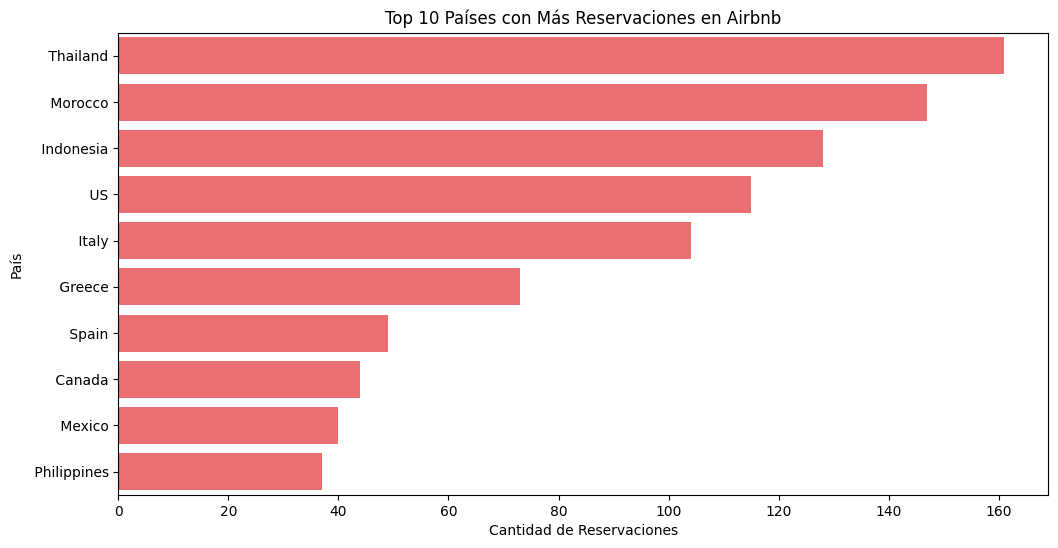

In [63]:
# Concatenamos los DataFrames por Pais
df_all = df1.select("Country").union(df2.select("Country")).union(df3.select("Country"))

# Convertimos a Pandas
df_all_pandas = df_all.toPandas()

# Agrupamos por país y contamos la cantidad de reservas
country_counts = df_all_pandas['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Tomamos los 10 países principales
top_10_countries = country_counts.head(10)

# Graficamos
plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Country", data=top_10_countries, palette=["#FF5A5F"])
plt.title("Top 10 Países con Más Reservaciones en Airbnb")
plt.xlabel("Cantidad de Reservaciones")
plt.ylabel("País")
plt.show()


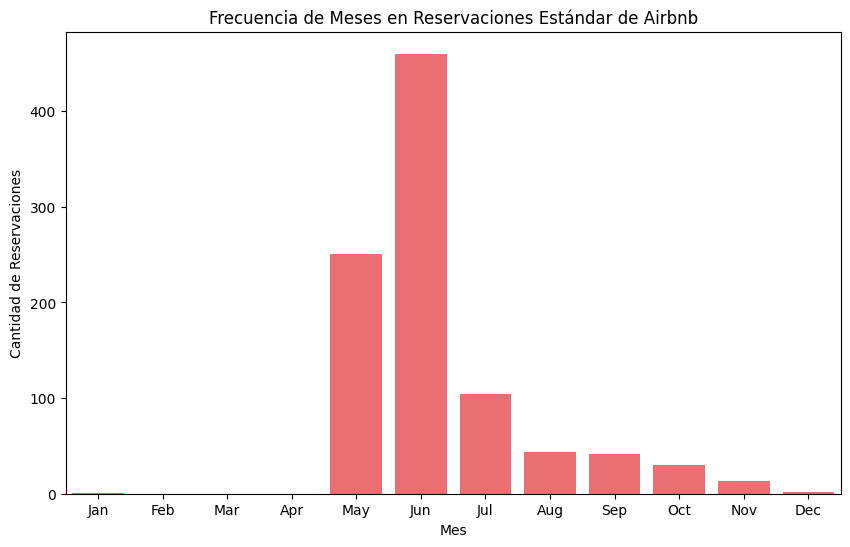

  Month  count
7   Jan      1
4   May    251
5   Jun    460
8   Jul    104
3   Aug     44
1   Sep     42
0   Oct     30
6   Nov     13
2   Dec      2


In [64]:
# Agrupamos y contamos los meses en df1
month_counts_df1 = df1.groupBy("Month").count().toPandas()

# Ordenamos los meses de enero a diciembre
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_counts_df1["Month"] = pd.Categorical(month_counts_df1["Month"], categories=month_order, ordered=True)
month_counts_df1 = month_counts_df1.sort_values("Month")

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x="Month", y="count", data=month_counts_df1, color="#FF5A5F")
plt.title("Frecuencia de Meses en Reservaciones Estándar de Airbnb")
plt.xlabel("Mes")
plt.ylabel("Cantidad de Reservaciones")
plt.show()

# No repetimos el proceso para df2 y df3 porque solo se tienen datos de mayo en estos datasets

print(month_counts_df1)

<ipython-input-65-36ebfb8e50a0>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-65-36ebfb8e50a0>:17: UserWarning:


The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.



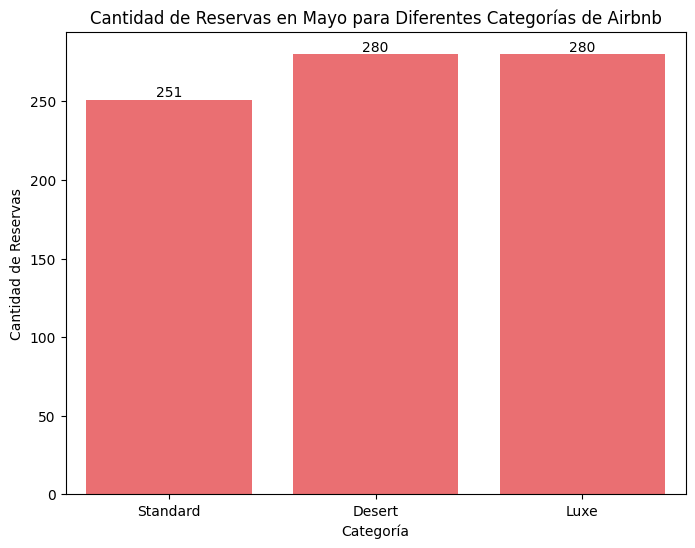

In [65]:
# Filtramos los DataFrames para el mes de mayo
df1_may = df1.filter(df1["Month"] == "May")
df2_may = df2.filter(df2["Month"] == "May")
df3_may = df3.filter(df3["Month"] == "May")

# Contamos las reservas para cada categoría
count_standard = df1_may.count()
count_desert = df2_may.count()
count_luxe = df3_may.count()

# Creamos un DataFrame de Pandas para la gráfica
data = {'Category': ['Standard', 'Desert', 'Luxe'], 'Count': [count_standard, count_desert, count_luxe]}
df_counts = pd.DataFrame(data)

# Graficamos
plt.figure(figsize=(8, 6))
sns.barplot(x="Category", y="Count", data=df_counts, palette=["#FF5A5F"])
plt.title("Cantidad de Reservas en Mayo para Diferentes Categorías de Airbnb")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de Reservas")

# Agregamos etiquetas a las barras
for index, row in df_counts.iterrows():
    plt.text(index, row['Count'], str(row['Count']), ha='center', va='bottom')

plt.show()


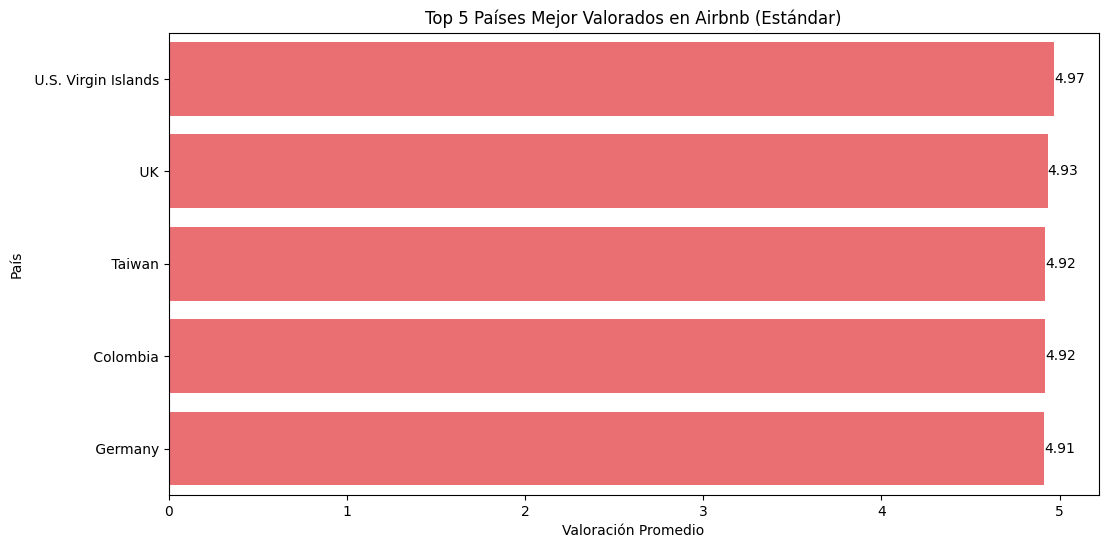

In [66]:
# Agrupamos por país y calculamos la valoración promedio, luego ordenamos y tomamos los 5 primeros
top_5_countries = df1_sorted.groupBy("Country").agg(avg("valoración").alias("avg_valoración")).orderBy(desc("avg_valoración")).limit(5).toPandas()

# Graficamos
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_valoración", y="Country", data=top_5_countries, color="#FF5A5F")
plt.title("Top 5 Países Mejor Valorados en Airbnb (Estándar)")
plt.xlabel("Valoración Promedio")
plt.ylabel("País")

for index, row in top_5_countries.iterrows():
    plt.text(row['avg_valoración'], index, f"{row['avg_valoración']:.2f}", va='center')

plt.show()


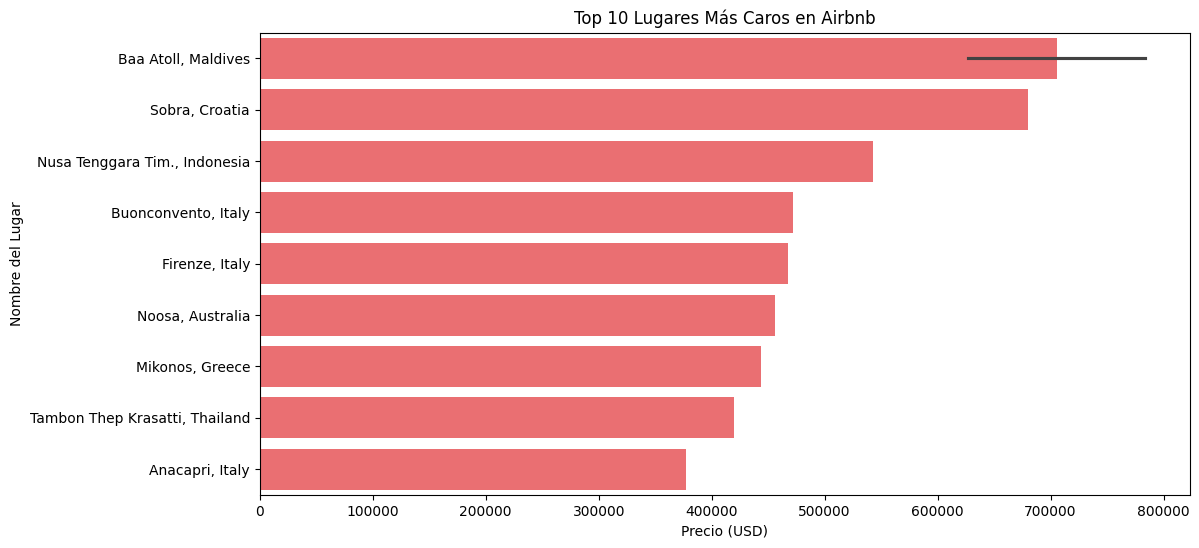

                             Name     Price Category     Country
0             Baa Atoll, Maldives  784000.0     Luxe    Maldives
1                  Sobra, Croatia  679628.0     Luxe     Croatia
2             Baa Atoll, Maldives  627200.0     Luxe    Maldives
3   Nusa Tenggara Tim., Indonesia  542500.0     Luxe   Indonesia
4             Buonconvento, Italy  472402.0     Luxe       Italy
5                  Firenze, Italy  467896.0     Luxe       Italy
6                Noosa, Australia  456350.0     Luxe   Australia
7                 Mikonos, Greece  443472.0     Luxe      Greece
8  Tambon Thep Krasatti, Thailand  420000.0     Luxe    Thailand
9                 Anacapri, Italy  377681.0     Luxe       Italy


In [67]:

# Ordenamos el DataFrame unido por precio en orden descendente y tomamos los 10 primeros
top_10_expensive = df_union.orderBy(desc("Price")).limit(10).toPandas()

# Graficamos los 10 lugares más caros
plt.figure(figsize=(12, 6))
sns.barplot(x="Price", y="Name", data=top_10_expensive, color="#FF5A5F")
plt.title("Top 10 Lugares Más Caros en Airbnb")
plt.xlabel("Precio (USD)")
plt.ylabel("Nombre del Lugar")
plt.show()

print(top_10_expensive)


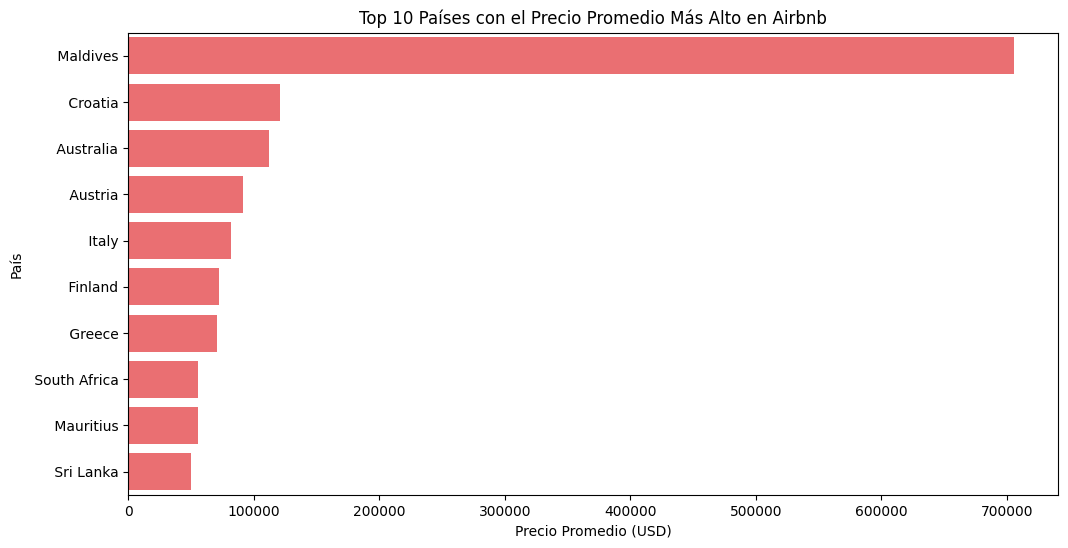

         Country      avg_price
0       Maldives  705600.000000
1        Croatia  120630.500000
2      Australia  112129.272727
3        Austria   91407.000000
4          Italy   81601.076923
5        Finland   72099.000000
6         Greece   70582.616438
7   South Africa   55857.461538
8      Mauritius   55577.000000
9      Sri Lanka   50400.000000


In [68]:
# Agrupa por país y calcula el precio promedio, luego ordena y toma los 10 primeros
top_10_countries = df_union.groupBy("Country").agg(avg("Price").alias("avg_price")).orderBy(desc("avg_price")).limit(10).toPandas()

# Grafica los 10 países con el precio promedio más alto
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_price", y="Country", data=top_10_countries, color="#FF5A5F")
plt.title("Top 10 Países con el Precio Promedio Más Alto en Airbnb")
plt.xlabel("Precio Promedio (USD)")
plt.ylabel("País")
plt.show()

print(top_10_countries)

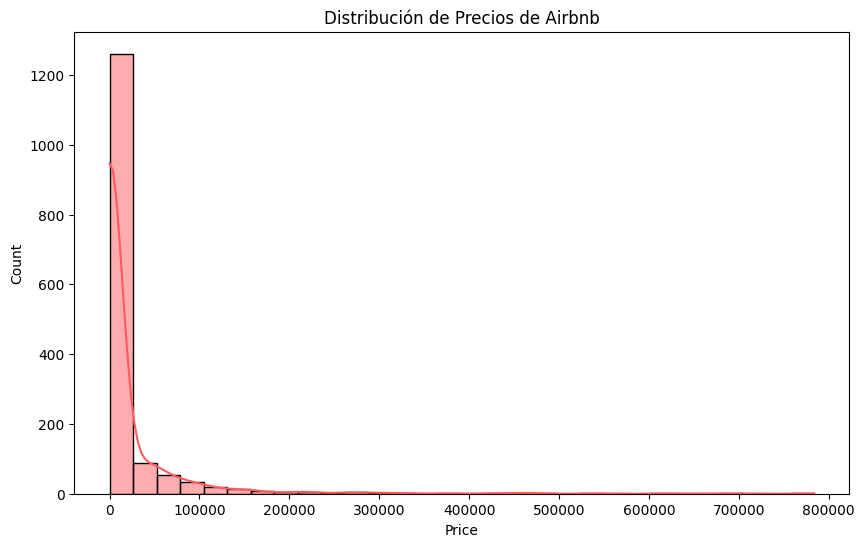

In [69]:
# Convertir a Pandas para la visualización
df_pandas = df_union.toPandas()


# Gráfico de la distribución de precios
plt.figure(figsize=(10,6))
sns.histplot(df_pandas['Price'], bins=30, kde=True, color="#FF5A5F")
plt.title("Distribución de Precios de Airbnb")
plt.show()

In [71]:
# Detener la sesión de Spark
SpSession.stop()